In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2D, Reshape
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout, Activation
from keras.optimizers import Adadelta, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import load_img,img_to_array
import cv2

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
train_img=[]
train_mask=[]

In [3]:
train = open("../VOC_2011_TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/train_2.txt", 'r')
lines = train.readlines()
for i, line in enumerate(lines):
    train_img.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/JPEGImages/"+line.split('\n')[0]+".jpg")
    train_mask.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/SegmentationClass/"+line.split('\n')[0]+".png")
train.close()

In [261]:
label_colors = np.array([(0, 0, 0),
  (192, 0, 128),
  (0, 128, 192),
  (0, 128, 64),
  (128, 0, 0),
  (64, 0, 128),
  (64, 0, 192),
  (192, 128, 64),
  (192, 192, 128),
  (64, 64, 128),
  (128, 0, 192),
  (192, 0, 64),
  (128, 128, 64),
  (192, 0, 192),
  (128, 64, 64),
  (64, 192, 128),
  (64, 64, 0),
  (128, 64, 128),
  (128, 128, 192),
  (0, 0, 192),
  (192, 128, 128)])

In [306]:
id2code ={0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128)}

id2name = {0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bridge',
 4: 'Building',
 5: 'Car',
 6: 'CartLuggagePram',
 7: 'Child',
 8: 'Column_Pole',
 9: 'Fence',
 10: 'LaneMkgsDriv',
 11: 'LaneMkgsNonDriv',
 12: 'Misc_Text',
 13: 'MotorcycleScooter',
 14: 'OtherMoving',
 15: 'ParkingBlock',
 16: 'Pedestrian',
 17: 'Road',
 18: 'RoadShoulder',
 19: 'Sidewalk',
 20: 'SignSymbol'}

In [307]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [308]:
rgb_to_onehot(cv2.imread(train_mask[0])).shape

(281, 500, 21)

In [309]:
onehot_to_rgb(rgb_to_onehot(cv2.imread(train_mask[0]))).shape

(281, 500, 3)

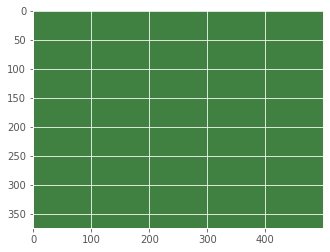

In [312]:
plt.imshow(onehot_to_rgb(rgb_to_onehot(cv2.imread(train_mask[3]))))

In [222]:
# Get and resize train images and masks
def get_data(img_path_list, mask_path_list, train=True):
    n_classes =21
    X = np.zeros((len(img_path_list), im_height, im_width, 3), dtype=np.float32)
    y = np.zeros((len(img_path_list), im_height, im_width, n_classes), dtype=np.float32)
    
    print('Getting and resizing images ... ')
    for n, img in tqdm_notebook(enumerate(img_path_list), total=len(img_path_list)):
        # Load images
        img = load_img(img)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128), mode='constant', preserve_range=True)

        mask = cv2.imread(mask_path_list[n],0)
        mask = cv2.resize(mask, (128,128), interpolation=cv2.INTER_NEAREST)
        
        one_hot = np.zeros((mask.shape[0], mask.shape[1], n_classes))
        for i , unique_value in enumerate(np.unique(mask)):
            one_hot[:, :, i][mask==unique_value]=1

        X[n] = x_img / 255.0
        if train:
            y[n] = one_hot
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train_img, train_mask, train=True)

Getting and resizing images ... 



Done!


In [223]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)

In [224]:
X_train.shape, y_train.shape

((105, 128, 128, 3), (105, 128, 128, 21))

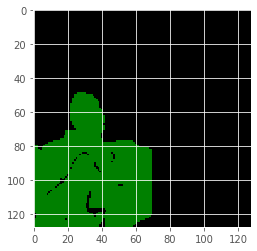

In [226]:
plt.imshow(decode_segmap(np.argmax(y_train[1].squeeze(), axis=2)))

In [215]:
one_hot.shape

(128, 128, 21)

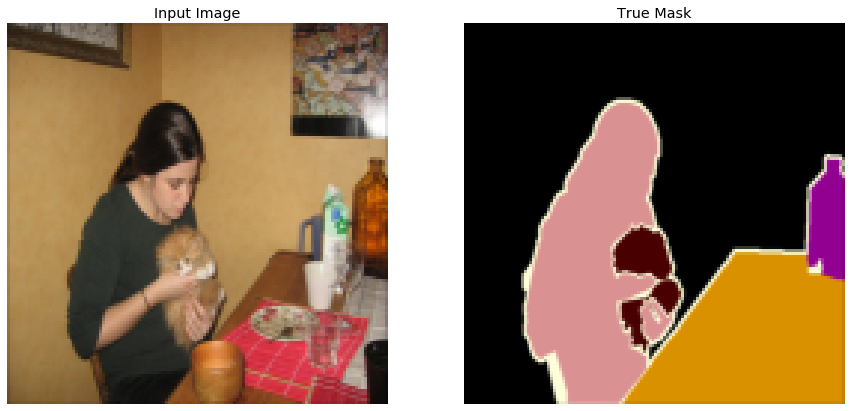

In [73]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

    

display([X_train[10], y_train[10]])

In [105]:
n_classes=20

img_input = Input(shape=(im_height, im_width, 3))

conv1=Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
conv1=Dropout(0.2)(conv1)
conv1=Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
pool1=MaxPooling2D((2,2))(conv1)

conv2=Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
conv2=Dropout(0.2)(conv2)
conv2=Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
pool2=MaxPooling2D((2,2))(conv2)

conv3=Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
conv3=Dropout(0.2)(conv3)
conv3=Conv2D(128, (3,3), activation='relu', padding='same')(conv3)

up1=concatenate([UpSampling2D((2,2))(conv3), conv2], axis=-1)
conv4=Conv2D(64, (3,3), activation='relu', padding='same')(up1)
conv4=Dropout(0.2)(conv4)
conv4=Conv2D(64, (3,3), activation='relu', padding='same')(conv4)

up2=concatenate([UpSampling2D((2,2))(conv4), conv1], axis=-1)
conv5=Conv2D(32, (3,3), activation='relu', padding='same')(up2)
conv5=Dropout(0.2)(conv5)
conv5=Conv2D(32, (3,3), activation='relu', padding='same')(conv5)

out=Conv2D(3, (1,1), padding='same')(conv5)

In [106]:

model = Model(img_input, out)
model.compile(optimizer=Adam(), loss='binary_crossentropy')

In [117]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_302 (Conv2D)             (None, 128, 128, 32) 896         input_17[0][0]                   
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 128, 128, 32) 0           conv2d_302[0][0]                 
__________________________________________________________________________________________________
conv2d_303 (Conv2D)             (None, 128, 128, 32) 9248        dropout_16[0][0]                 
___________________________________________________________________________________________

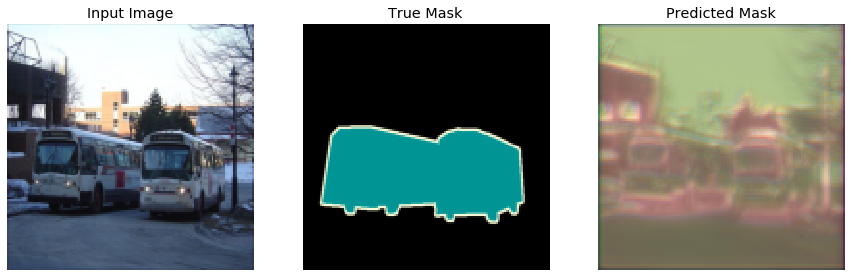

In [127]:
display([X_train[0], y_train[0],model.predict(X_train[0].reshape(1,128,128,3)).reshape(128,128,3)*255.0])

In [109]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [111]:
EPOCHS = 5
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE

model_history = model.fit(X_train, y_train,  epochs=EPOCHS)

Epoch 1/5
105/105 [==============================] - ETA: 29s - loss: 0.50 - ETA: 17s - loss: 0.47 - ETA: 3s - loss: 0.4584 - 36s 346ms/step - loss: 0.4593
Epoch 2/5
105/105 [==============================] - ETA: 14s - loss: 0.40 - ETA: 9s - loss: 0.3880 - ETA: 2s - loss: 0.398 - 24s 232ms/step - loss: 0.4087
Epoch 3/5
105/105 [==============================] - ETA: 16s - loss: 0.46 - ETA: 9s - loss: 0.4059 - ETA: 2s - loss: 0.409 - 25s 242ms/step - loss: 0.4007
Epoch 4/5
105/105 [==============================] - ETA: 16s - loss: 0.39 - ETA: 8s - loss: 0.3906 - ETA: 1s - loss: 0.399 - 22s 209ms/step - loss: 0.3927
Epoch 5/5
105/105 [==============================] - ETA: 17s - loss: 0.38 - ETA: 9s - loss: 0.3927 - ETA: 2s - loss: 0.382 - 24s 232ms/step - loss: 0.3846


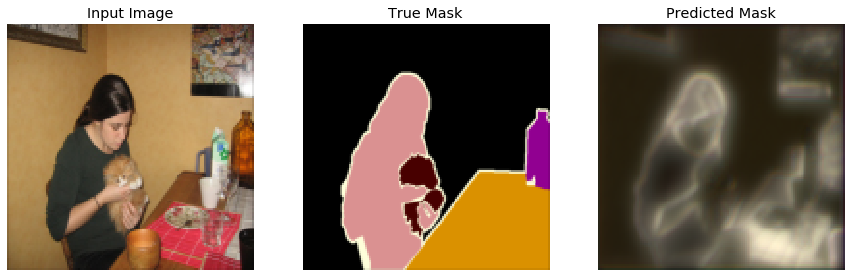

In [136]:
i=10
display([X_train[i], y_train[i],model.predict(X_train[i].reshape(1,128,128,3)).reshape(128,128,3)*255.0])

In [134]:
model.predict(X_train[i].reshape(1,128,128,3)).shape

(1, 128, 128, 3)

In [227]:
def segnet(input_img, n_classes):
    
    x = BatchNormalization()(input_img)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Up Block 1
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 2
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 3
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 4
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 5
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    x = Conv2D(21, (1, 1), activation='linear', padding='same')(x)
    
    model = Model(inputs=[input_img], outputs=[x])
    return model

In [ ]:
input_img = Input((im_height, im_width, 3), name='img')


model = segnet(input_img, n_classes=21)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

In [234]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       1475

In [231]:
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

results = model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Train on 105 samples, validate on 19 samples
Epoch 1/100
105/105 [==============================] - ETA: 1:57 - loss: 5.8375 - accuracy: 0.0000e+ - ETA: 1:06 - loss: 5.8339 - accuracy: 0.0000e+ - ETA: 14s - loss: 5.8327 - accuracy: 0.0000e+00 - 183s 2s/step - loss: 5.8325 - accuracy: 0.0000e+00 - val_loss: 5.8308 - val_accuracy: 0.0000e+00
Epoch 2/100


KeyboardInterrupt: 

In [187]:
i=10
display([X_valid[i], y_valid[i],model.predict(X_valid[i].reshape(1,128,128,3)).reshape(128,128,3)*255.0])

ValueError: cannot reshape array of size 327680 into shape (128,128,3)